In [1]:
!nvidia-smi

Tue Apr 30 09:57:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   48C    P8              2W /  140W |     402MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# import the libraries
import torch, pdb, os
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm import tqdm # progress bar lib
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [3]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor: 128 X 784
  data = tensor.detach().cpu().view(-1,ch,*size) # detaching the tensor to the cpu
  grid = make_grid(data[:num], nrow=4).permute(1,2,0) # changing the shape of the dimensional grid from "ch x wh x hg" to "wh x hg x ch"
  plt.imshow(grid)
  plt.show()

def save_img(tensor, ch=1, size=(28,28), num=16):
  # tensor: 128 X 784
  save_img_path = create_img_folder() # create 'images' folder to save all the training images (for further progress checking)
  data = tensor.detach().cpu().view(-1,ch,*size) # detaching the tensor to the cpu
  grid = make_grid(data[:num], nrow=4).permute(1,2,0) # changing the shape of the dimensional grid from "ch x wh x hg" to "wh x hg x ch"
  plt.imshow(grid)
  plt.savefig(f'{save_img_path}\\{output_img_counter}.jpg', bbox_inches='tight')
  # plt.show()

def create_img_folder():
    # funtion to create a folder (if it not exists) to save the images
    current_dir = os.path.dirname(os.path.abspath(''))
    
    folder_path = f'{current_dir}\\images'
    # os.mkdir(parents=True, exist_ok=True)

    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)
        return folder_path
    else:
        return folder_path

In [4]:
# setup of the main parameters and hyperparameters
epochs = 1500 # number of times that the network will be trained
cur_step = 0 # the current training batch
info_step = 3000 # at a determined info_step times, the current training will be show in the screen
mean_gen_loss = 0 # accumulate the generator loss
mean_disc_loss = 0 # accumulate the discriminator loss

z_dim = 64 # input of the generator (Latent space noise vector)
learning_rate = 0.00001
loss_func = nn.BCEWithLogitsLoss() # apply the activation function and the return the loss value

batch_size = 128 # how many images will be processed
device = 'cuda' # defines what will be the device used on training

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=batch_size)

output_img_counter = 0 # variable to name the images in output in order

# number of steps in training = len(dataset) / batch_size = 60000 / 128 = 468,75 ~ 469

In [5]:
from torch.nn.modules.batchnorm import BatchNorm1d
# declare the models

# Generator Model
def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        # always (input, output)
        genBlock(z_dim, h_dim), # 64 = 128
        genBlock(h_dim, h_dim*2), # 128 = 256
        genBlock(h_dim*2, h_dim*4), # 256 = 512
        genBlock(h_dim*4, h_dim*8), # 512 = 1024
        nn.Linear(h_dim*8, i_dim), # 1024 = 784 (28X28)
        nn.Sigmoid()
    )

  def forward(self, noise):
    return self.gen(noise)

def gen_noise(number, z_dim):
  ## function to produce noise random numbers to the generator
  return torch.randn(number, z_dim).to(device)

## Discriminator Model
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc = nn.Sequential(
        # always (input, output)
        discBlock(i_dim, h_dim*4), # 784 = 1024
        discBlock(h_dim*4, h_dim*2), # 1024 = 512 
        discBlock(h_dim*2, h_dim), # 512 = 256
        nn.Linear(h_dim, 1) # 256 = 1
    )

  def forward(self, image):
    return self.disc(image)

In [6]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=learning_rate)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=learning_rate)

In [7]:
print("Generator Structure")
gen

Generator Structure


Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [8]:
print("Discriminator Structure")
disc

Discriminator Structure


Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([7, 9, 2, 9, 6, 6, 4, 0, 5, 9])


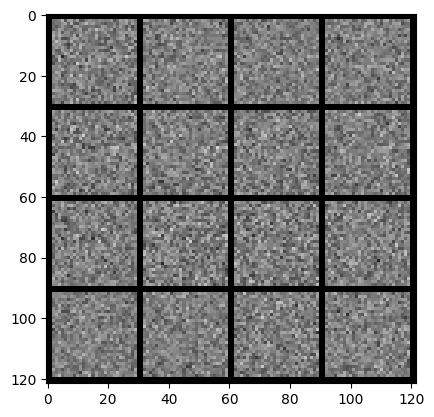

In [9]:
x,y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

In [10]:
# Calculating the Loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  # function to calculate the generate model loss
  noise = gen_noise(number, z_dim) # generate a probabilistic noise values
  fake = gen(noise) # generate a image with the noise
  pred = disc(fake) # pass it through the discriminator model, to predict if the image generated are next to real (real = trained database)
  targets = torch.ones_like(pred) # generate a structure like the predicted filled with ones

  gen_loss = loss_func(pred, targets) # caculate the loss between the prediction and the target

  return gen_loss

def calc_disc_loss(loss_func, gen, disc, number, real_img, z_dim):
  # function to calculate the discriminator model loss
  noise = gen_noise(number, z_dim) # generate a probabilistic noise values
  fake = gen(noise) # generate a image with the noise
  disc_fake = disc(fake.detach()) # pass it through the discriminator model with fake data
  disc_fake_targets = torch.zeros_like(disc_fake) # generate a structure like the predicted filled with zeros

  disc_fake_loss = loss_func(disc_fake, disc_fake_targets) # caculate the loss between the prediction and the target

  disc_real = disc(real_img) # pass it through the discriminator model with real data
  disc_real_targets = torch.ones_like(disc_real) # generate a structure like the predicted filled with ones

  disc_real_loss = loss_func(disc_real, disc_real_targets) # caculate the loss between the prediction and the target

  disc_loss = (disc_fake_loss + disc_real_loss) / 2

  return disc_loss

 42%|█████████████████████████████████████████████████████████████▌                                                                                   | 199/469 [00:02<00:04, 61.47it/s]

6: step 3000 / Gen Loss: 0.07782489333643286 / Disc Loss: 0.07782489333643286


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 386/469 [00:05<00:01, 61.59it/s]

12: step 6000 / Gen Loss: 0.018746971094592804 / Disc Loss: 0.018746971094592804


 21%|██████████████████████████████▏                                                                                                                   | 97/469 [00:01<00:06, 57.77it/s]

19: step 9000 / Gen Loss: 0.011116175014525668 / Disc Loss: 0.011116175014525668


 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                        | 288/469 [00:04<00:02, 60.62it/s]

25: step 12000 / Gen Loss: 0.012499048857406393 / Disc Loss: 0.012499048857406393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.49it/s]


31: step 15000 / Gen Loss: 0.019366112497014316 / Disc Loss: 0.019366112497014316


 41%|███████████████████████████████████████████████████████████▉                                                                                     | 194/469 [00:02<00:04, 60.43it/s]

38: step 18000 / Gen Loss: 0.028549202375890027 / Disc Loss: 0.028549202375890027


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 374/469 [00:05<00:01, 59.08it/s]

44: step 21000 / Gen Loss: 0.04212814706113815 / Disc Loss: 0.04212814706113815


 19%|████████████████████████████                                                                                                                      | 90/469 [00:01<00:06, 57.60it/s]

51: step 24000 / Gen Loss: 0.06410192348714915 / Disc Loss: 0.06410192348714915


 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                           | 278/469 [00:04<00:04, 46.54it/s]

57: step 27000 / Gen Loss: 0.0899031579941511 / Disc Loss: 0.0899031579941511


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 72.62it/s]

63: step 30000 / Gen Loss: 0.10064370703324657 / Disc Loss: 0.10064370703324657



 38%|███████████████████████████████████████████████████████▋                                                                                         | 180/469 [00:03<00:06, 46.24it/s]

70: step 33000 / Gen Loss: 0.1037913814174633 / Disc Loss: 0.1037913814174633


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 362/469 [00:06<00:02, 53.06it/s]

76: step 36000 / Gen Loss: 0.1328513342787824 / Disc Loss: 0.1328513342787824


 18%|██████████████████████████▏                                                                                                                       | 84/469 [00:01<00:07, 53.86it/s]

83: step 39000 / Gen Loss: 0.14370022313421002 / Disc Loss: 0.14370022313421002


 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                            | 273/469 [00:04<00:04, 48.28it/s]

89: step 42000 / Gen Loss: 0.1629456101295849 / Disc Loss: 0.1629456101295849


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 460/469 [00:06<00:00, 54.59it/s]

95: step 45000 / Gen Loss: 0.18161372456202882 / Disc Loss: 0.18161372456202882


 36%|████████████████████████████████████████████████████▌                                                                                            | 170/469 [00:02<00:06, 44.41it/s]

102: step 48000 / Gen Loss: 0.18611720151205843 / Disc Loss: 0.18611720151205843


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 358/469 [00:05<00:02, 44.62it/s]

108: step 51000 / Gen Loss: 0.20594001705199497 / Disc Loss: 0.20594001705199497


 16%|███████████████████████▎                                                                                                                          | 75/469 [00:01<00:08, 44.41it/s]

115: step 54000 / Gen Loss: 0.2129424516558649 / Disc Loss: 0.2129424516558649


 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                               | 263/469 [00:03<00:04, 46.99it/s]

121: step 57000 / Gen Loss: 0.23370495195438526 / Disc Loss: 0.23370495195438526


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 448/469 [00:06<00:00, 42.54it/s]

127: step 60000 / Gen Loss: 0.24693783445904646 / Disc Loss: 0.24693783445904646


 35%|██████████████████████████████████████████████████                                                                                               | 162/469 [00:02<00:07, 42.47it/s]

134: step 63000 / Gen Loss: 0.25614890511830685 / Disc Loss: 0.25614890511830685


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 352/469 [00:05<00:02, 43.77it/s]

140: step 66000 / Gen Loss: 0.26426299563546984 / Disc Loss: 0.26426299563546984


 14%|████████████████████▌                                                                                                                             | 66/469 [00:01<00:09, 44.24it/s]

147: step 69000 / Gen Loss: 0.2813370247681937 / Disc Loss: 0.2813370247681937


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                 | 256/469 [00:03<00:04, 48.81it/s]

153: step 72000 / Gen Loss: 0.2846265969773133 / Disc Loss: 0.2846265969773133


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 441/469 [00:06<00:00, 46.08it/s]

159: step 75000 / Gen Loss: 0.2900394042780004 / Disc Loss: 0.2900394042780004


 33%|███████████████████████████████████████████████▌                                                                                                 | 154/469 [00:02<00:07, 44.45it/s]

166: step 78000 / Gen Loss: 0.281876311774055 / Disc Loss: 0.281876311774055


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 343/469 [00:04<00:02, 46.64it/s]

172: step 81000 / Gen Loss: 0.3232238080153856 / Disc Loss: 0.3232238080153856


 13%|██████████████████▋                                                                                                                               | 60/469 [00:01<00:12, 32.79it/s]

179: step 84000 / Gen Loss: 0.3128592082907765 / Disc Loss: 0.3128592082907765


 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 244/469 [00:03<00:05, 42.83it/s]

185: step 87000 / Gen Loss: 0.3354232344577707 / Disc Loss: 0.3354232344577707


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 433/469 [00:06<00:00, 46.95it/s]

191: step 90000 / Gen Loss: 0.3533882444649942 / Disc Loss: 0.3533882444649942


 31%|████████████████████████████████████████████▌                                                                                                    | 144/469 [00:02<00:10, 30.64it/s]

198: step 93000 / Gen Loss: 0.3649474308490748 / Disc Loss: 0.3649474308490748


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 335/469 [00:04<00:02, 45.63it/s]

204: step 96000 / Gen Loss: 0.37373258235057244 / Disc Loss: 0.37373258235057244


 11%|███████████████▉                                                                                                                                  | 51/469 [00:01<00:11, 37.61it/s]

211: step 99000 / Gen Loss: 0.3732211120675006 / Disc Loss: 0.3732211120675006


 49%|███████████████████████████████████████████████████████████████████████▍                                                                         | 231/469 [00:03<00:08, 27.78it/s]

217: step 102000 / Gen Loss: 0.3970443660020838 / Disc Loss: 0.3970443660020838


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 428/469 [00:06<00:00, 44.73it/s]

223: step 105000 / Gen Loss: 0.4394206705788778 / Disc Loss: 0.4394206705788778


 30%|███████████████████████████████████████████▉                                                                                                     | 142/469 [00:02<00:07, 42.80it/s]

230: step 108000 / Gen Loss: 0.4195710480312506 / Disc Loss: 0.4195710480312506


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 322/469 [00:04<00:04, 35.42it/s]

236: step 111000 / Gen Loss: 0.4351051756441593 / Disc Loss: 0.4351051756441593


 10%|██████████████                                                                                                                                    | 45/469 [00:01<00:13, 31.92it/s]

243: step 114000 / Gen Loss: 0.4520401133994263 / Disc Loss: 0.4520401133994263


 49%|██████████████████████████████████████████████████████████████████████▍                                                                          | 228/469 [00:04<00:06, 35.26it/s]

249: step 117000 / Gen Loss: 0.45516088840365376 / Disc Loss: 0.45516088840365376


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 413/469 [00:06<00:01, 36.93it/s]

255: step 120000 / Gen Loss: 0.4769350390334938 / Disc Loss: 0.4769350390334938


 28%|████████████████████████████████████████▌                                                                                                        | 131/469 [00:02<00:08, 41.13it/s]

262: step 123000 / Gen Loss: 0.48781185753146733 / Disc Loss: 0.48781185753146733


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 315/469 [00:05<00:04, 36.43it/s]

268: step 126000 / Gen Loss: 0.479615615328153 / Disc Loss: 0.479615615328153


  7%|██████████▌                                                                                                                                       | 34/469 [00:00<00:12, 33.76it/s]

275: step 129000 / Gen Loss: 0.4848016001880174 / Disc Loss: 0.4848016001880174


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 219/469 [00:03<00:07, 31.83it/s]

281: step 132000 / Gen Loss: 0.4884256149729093 / Disc Loss: 0.4884256149729093


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 404/469 [00:06<00:01, 32.91it/s]

287: step 135000 / Gen Loss: 0.511039508640766 / Disc Loss: 0.511039508640766


 26%|██████████████████████████████████████▎                                                                                                          | 124/469 [00:02<00:08, 38.95it/s]

294: step 138000 / Gen Loss: 0.5038385260701167 / Disc Loss: 0.5038385260701167


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 308/469 [00:04<00:04, 33.60it/s]

300: step 141000 / Gen Loss: 0.5213613063693051 / Disc Loss: 0.5213613063693051


  5%|███████▍                                                                                                                                          | 24/469 [00:00<00:17, 25.30it/s]

307: step 144000 / Gen Loss: 0.5275276201268031 / Disc Loss: 0.5275276201268031


 46%|██████████████████████████████████████████████████████████████████▏                                                                              | 214/469 [00:03<00:07, 33.84it/s]

313: step 147000 / Gen Loss: 0.528286744366089 / Disc Loss: 0.528286744366089


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 398/469 [00:06<00:01, 39.00it/s]

319: step 150000 / Gen Loss: 0.5261442954043547 / Disc Loss: 0.5261442954043547


 25%|███████████████████████████████████▌                                                                                                             | 115/469 [00:02<00:09, 38.04it/s]

326: step 153000 / Gen Loss: 0.5422178432444745 / Disc Loss: 0.5422178432444745


 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 299/469 [00:04<00:05, 30.86it/s]

332: step 156000 / Gen Loss: 0.510595990190903 / Disc Loss: 0.510595990190903


  3%|████▉                                                                                                                                             | 16/469 [00:00<00:20, 21.73it/s]

339: step 159000 / Gen Loss: 0.5196181330382822 / Disc Loss: 0.5196181330382822


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 203/469 [00:03<00:08, 30.40it/s]

345: step 162000 / Gen Loss: 0.5346454027195758 / Disc Loss: 0.5346454027195758


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 396/469 [00:05<00:01, 37.72it/s]

351: step 165000 / Gen Loss: 0.5407191895445187 / Disc Loss: 0.5407191895445187


 23%|█████████████████████████████████                                                                                                                | 107/469 [00:02<00:12, 30.03it/s]

358: step 168000 / Gen Loss: 0.5340479261080433 / Disc Loss: 0.5340479261080433


 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 298/469 [00:04<00:04, 36.64it/s]

364: step 171000 / Gen Loss: 0.5289588641226296 / Disc Loss: 0.5289588641226296


  4%|█████▎                                                                                                                                            | 17/469 [00:00<00:15, 29.23it/s]

371: step 174000 / Gen Loss: 0.5942623061239701 / Disc Loss: 0.5942623061239701


 42%|████████████████████████████████████████████████████████████▌                                                                                    | 196/469 [00:03<00:08, 32.87it/s]

377: step 177000 / Gen Loss: 0.5535731855432198 / Disc Loss: 0.5535731855432198


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 385/469 [00:06<00:02, 36.68it/s]

383: step 180000 / Gen Loss: 0.5138645747701334 / Disc Loss: 0.5138645747701334


 22%|███████████████████████████████▏                                                                                                                 | 101/469 [00:02<00:11, 32.90it/s]

390: step 183000 / Gen Loss: 0.5220153384009992 / Disc Loss: 0.5220153384009992


 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                        | 288/469 [00:05<00:06, 27.16it/s]

396: step 186000 / Gen Loss: 0.6255013511180895 / Disc Loss: 0.6255013511180895


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 65.23it/s]


402: step 189000 / Gen Loss: 0.5691041455169525 / Disc Loss: 0.5691041455169525


 39%|████████████████████████████████████████████████████████▉                                                                                        | 184/469 [00:03<00:10, 26.17it/s]

409: step 192000 / Gen Loss: 0.5370859602689741 / Disc Loss: 0.5370859602689741


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 378/469 [00:05<00:02, 33.40it/s]

415: step 195000 / Gen Loss: 0.5239001428782939 / Disc Loss: 0.5239001428782939


 19%|███████████████████████████▋                                                                                                                      | 89/469 [00:02<00:16, 22.65it/s]

422: step 198000 / Gen Loss: 0.5383853730857383 / Disc Loss: 0.5383853730857383


 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                         | 282/469 [00:04<00:05, 32.31it/s]

428: step 201000 / Gen Loss: 0.5166040123601761 / Disc Loss: 0.5166040123601761


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 464/469 [00:07<00:00, 32.37it/s]

434: step 204000 / Gen Loss: 0.5195098335842294 / Disc Loss: 0.5195098335842294


 38%|███████████████████████████████████████████████████████▋                                                                                         | 180/469 [00:03<00:09, 30.42it/s]

441: step 207000 / Gen Loss: 0.5166189862390372 / Disc Loss: 0.5166189862390372


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 366/469 [00:05<00:03, 32.12it/s]

447: step 210000 / Gen Loss: 0.5283278067906694 / Disc Loss: 0.5283278067906694


 17%|█████████████████████████▌                                                                                                                        | 82/469 [00:02<00:17, 22.33it/s]

454: step 213000 / Gen Loss: 0.5200067835052812 / Disc Loss: 0.5200067835052812


 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                             | 270/469 [00:04<00:07, 26.38it/s]

460: step 216000 / Gen Loss: 0.5148920602003729 / Disc Loss: 0.5148920602003729


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 461/469 [00:07<00:00, 31.18it/s]

466: step 219000 / Gen Loss: 0.5041698509355369 / Disc Loss: 0.5041698509355369


 36%|████████████████████████████████████████████████████▌                                                                                            | 170/469 [00:02<00:09, 32.44it/s]

473: step 222000 / Gen Loss: 0.5139937332669895 / Disc Loss: 0.5139937332669895


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 358/469 [00:05<00:04, 24.64it/s]

479: step 225000 / Gen Loss: 0.5146268913348506 / Disc Loss: 0.5146268913348506


 15%|██████████████████████▍                                                                                                                           | 72/469 [00:02<00:17, 22.16it/s]

486: step 228000 / Gen Loss: 0.5101599356532099 / Disc Loss: 0.5101599356532099


 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                | 260/469 [00:05<00:08, 23.74it/s]

492: step 231000 / Gen Loss: 0.5141713358660542 / Disc Loss: 0.5141713358660542


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 446/469 [00:07<00:00, 26.74it/s]

498: step 234000 / Gen Loss: 0.5172176413834098 / Disc Loss: 0.5172176413834098


 34%|█████████████████████████████████████████████████▊                                                                                               | 161/469 [00:03<00:15, 20.29it/s]

505: step 237000 / Gen Loss: 0.4918418313960239 / Disc Loss: 0.4918418313960239


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 352/469 [00:05<00:04, 25.68it/s]

511: step 240000 / Gen Loss: 0.49715475576122686 / Disc Loss: 0.49715475576122686


 14%|████████████████████▌                                                                                                                             | 66/469 [00:01<00:14, 27.05it/s]

518: step 243000 / Gen Loss: 0.576959243347248 / Disc Loss: 0.576959243347248


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 247/469 [00:05<00:14, 15.75it/s]

524: step 246000 / Gen Loss: 0.5244822399417568 / Disc Loss: 0.5244822399417568


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 439/469 [00:07<00:01, 28.18it/s]

530: step 249000 / Gen Loss: 0.4954512377182641 / Disc Loss: 0.4954512377182641


 33%|███████████████████████████████████████████████▌                                                                                                 | 154/469 [00:03<00:22, 13.75it/s]

537: step 252000 / Gen Loss: 0.5115962208807472 / Disc Loss: 0.5115962208807472


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 341/469 [00:05<00:05, 23.29it/s]

543: step 255000 / Gen Loss: 0.5374142797589306 / Disc Loss: 0.5374142797589306


 12%|█████████████████▋                                                                                                                                | 57/469 [00:01<00:20, 20.41it/s]

550: step 258000 / Gen Loss: 0.4944240661362815 / Disc Loss: 0.4944240661362815


 52%|██████████████████████████████████████████████████████████████████████████▊                                                                      | 242/469 [00:04<00:12, 18.44it/s]

556: step 261000 / Gen Loss: 0.4999917294383044 / Disc Loss: 0.4999917294383044


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 436/469 [00:06<00:01, 27.78it/s]

562: step 264000 / Gen Loss: 0.5170849080284445 / Disc Loss: 0.5170849080284445


 31%|█████████████████████████████████████████████▍                                                                                                   | 147/469 [00:02<00:11, 28.03it/s]

569: step 267000 / Gen Loss: 0.5484465447862945 / Disc Loss: 0.5484465447862945


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 331/469 [00:06<00:11, 12.47it/s]

575: step 270000 / Gen Loss: 0.4882194396952787 / Disc Loss: 0.4882194396952787


 11%|███████████████▉                                                                                                                                  | 51/469 [00:02<00:24, 16.77it/s]

582: step 273000 / Gen Loss: 0.5204684467315663 / Disc Loss: 0.5204684467315663


 50%|████████████████████████████████████████████████████████████████████████▋                                                                        | 235/469 [00:04<00:12, 19.07it/s]

588: step 276000 / Gen Loss: 0.5011503922839969 / Disc Loss: 0.5011503922839969


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 426/469 [00:06<00:01, 28.23it/s]

594: step 279000 / Gen Loss: 0.49001727170745657 / Disc Loss: 0.49001727170745657


 30%|███████████████████████████████████████████▉                                                                                                     | 142/469 [00:02<00:13, 25.03it/s]

601: step 282000 / Gen Loss: 0.5051200134555507 / Disc Loss: 0.5051200134555507


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 329/469 [00:06<00:05, 26.16it/s]

607: step 285000 / Gen Loss: 0.4929056473275026 / Disc Loss: 0.4929056473275026


  9%|█████████████                                                                                                                                     | 42/469 [00:01<00:20, 20.43it/s]

614: step 288000 / Gen Loss: 0.4944217758874099 / Disc Loss: 0.4944217758874099


 49%|███████████████████████████████████████████████████████████████████████                                                                          | 230/469 [00:04<00:09, 25.99it/s]

620: step 291000 / Gen Loss: 0.5005345600346728 / Disc Loss: 0.5005345600346728


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 418/469 [00:06<00:01, 25.62it/s]

626: step 294000 / Gen Loss: 0.5217929212450977 / Disc Loss: 0.5217929212450977


 28%|████████████████████████████████████████▊                                                                                                        | 132/469 [00:03<00:14, 23.43it/s]

633: step 297000 / Gen Loss: 0.4748774474561215 / Disc Loss: 0.4748774474561215


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 321/469 [00:05<00:06, 23.33it/s]

639: step 300000 / Gen Loss: 0.49404588891069035 / Disc Loss: 0.49404588891069035


  8%|███████████▏                                                                                                                                      | 36/469 [00:01<00:20, 21.44it/s]

646: step 303000 / Gen Loss: 0.4883401444454998 / Disc Loss: 0.4883401444454998


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 225/469 [00:04<00:08, 27.40it/s]

652: step 306000 / Gen Loss: 0.5400665356616181 / Disc Loss: 0.5400665356616181


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 410/469 [00:06<00:02, 26.17it/s]

658: step 309000 / Gen Loss: 0.723654393017294 / Disc Loss: 0.723654393017294


 26%|██████████████████████████████████████▎                                                                                                          | 124/469 [00:02<00:14, 24.53it/s]

665: step 312000 / Gen Loss: 0.5142649867633983 / Disc Loss: 0.5142649867633983


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 312/469 [00:05<00:06, 22.88it/s]

671: step 315000 / Gen Loss: 0.5239090948303541 / Disc Loss: 0.5239090948303541


  6%|████████                                                                                                                                          | 26/469 [00:01<00:24, 17.86it/s]

678: step 318000 / Gen Loss: 0.53028594793876 / Disc Loss: 0.53028594793876


 45%|█████████████████████████████████████████████████████████████████▏                                                                               | 211/469 [00:03<00:10, 24.40it/s]

684: step 321000 / Gen Loss: 0.5283280197978025 / Disc Loss: 0.5283280197978025


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 396/469 [00:07<00:04, 16.68it/s]

690: step 324000 / Gen Loss: 0.5263024514317518 / Disc Loss: 0.5263024514317518


 25%|████████████████████████████████████▊                                                                                                            | 119/469 [00:02<00:14, 24.14it/s]

697: step 327000 / Gen Loss: 0.5337748449643452 / Disc Loss: 0.5337748449643452


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 304/469 [00:06<00:10, 15.57it/s]

703: step 330000 / Gen Loss: 0.5601711087624216 / Disc Loss: 0.5601711087624216


  4%|█████▎                                                                                                                                            | 17/469 [00:01<00:31, 14.34it/s]

710: step 333000 / Gen Loss: 0.5049805495838312 / Disc Loss: 0.5049805495838312


 43%|███████████████████████████████████████████████████████████████                                                                                  | 204/469 [00:04<00:13, 19.74it/s]

716: step 336000 / Gen Loss: 0.5124048335353535 / Disc Loss: 0.5124048335353535


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 388/469 [00:08<00:07, 10.65it/s]

722: step 339000 / Gen Loss: 0.5120190094014012 / Disc Loss: 0.5120190094014012


 23%|█████████████████████████████████                                                                                                                | 107/469 [00:03<00:24, 14.53it/s]

729: step 342000 / Gen Loss: 0.4990953254004317 / Disc Loss: 0.4990953254004317


 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 290/469 [00:06<00:16, 11.18it/s]

735: step 345000 / Gen Loss: 0.5070881530642499 / Disc Loss: 0.5070881530642499


  2%|██▌                                                                                                                                                | 8/469 [00:01<01:09,  6.60it/s]

742: step 348000 / Gen Loss: 0.49808765506744374 / Disc Loss: 0.49808765506744374


 42%|████████████████████████████████████████████████████████████▎                                                                                    | 195/469 [00:04<00:19, 14.25it/s]

748: step 351000 / Gen Loss: 0.48853367685278287 / Disc Loss: 0.48853367685278287


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 382/469 [00:07<00:04, 18.52it/s]

754: step 354000 / Gen Loss: 0.4765450258453683 / Disc Loss: 0.4765450258453683


 21%|██████████████████████████████▊                                                                                                                   | 99/469 [00:02<00:23, 15.90it/s]

761: step 357000 / Gen Loss: 0.5013910827040688 / Disc Loss: 0.5013910827040688


 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                         | 282/469 [00:05<00:11, 15.96it/s]

767: step 360000 / Gen Loss: 0.4983664423624683 / Disc Loss: 0.4983664423624683


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 53.01it/s]


773: step 363000 / Gen Loss: 0.4812918756008153 / Disc Loss: 0.4812918756008153


 40%|██████████████████████████████████████████████████████████▍                                                                                      | 189/469 [00:04<00:17, 15.66it/s]

780: step 366000 / Gen Loss: 0.4759897701044873 / Disc Loss: 0.4759897701044873


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 374/469 [00:07<00:05, 17.39it/s]

786: step 369000 / Gen Loss: 0.481831377406915 / Disc Loss: 0.481831377406915


 20%|████████████████████████████▉                                                                                                                     | 93/469 [00:02<00:22, 16.41it/s]

793: step 372000 / Gen Loss: 0.4806426751315588 / Disc Loss: 0.4806426751315588


 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                           | 277/469 [00:05<00:12, 15.95it/s]

799: step 375000 / Gen Loss: 0.48143619714180685 / Disc Loss: 0.48143619714180685


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 461/469 [00:09<00:00, 13.43it/s]

805: step 378000 / Gen Loss: 0.4947386296490829 / Disc Loss: 0.4947386296490829


 39%|███████████████████████████████████████████████████████▉                                                                                         | 181/469 [00:04<00:15, 18.03it/s]

812: step 381000 / Gen Loss: 0.5449955286780976 / Disc Loss: 0.5449955286780976


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 370/469 [00:06<00:05, 17.71it/s]

818: step 384000 / Gen Loss: 0.48228905268510097 / Disc Loss: 0.48228905268510097


 18%|██████████████████████████▏                                                                                                                       | 84/469 [00:02<00:24, 15.70it/s]

825: step 387000 / Gen Loss: 0.48588439896702873 / Disc Loss: 0.48588439896702873


 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                              | 268/469 [00:05<00:17, 11.59it/s]

831: step 390000 / Gen Loss: 0.5395317996541661 / Disc Loss: 0.5395317996541661


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 456/469 [00:09<00:00, 13.95it/s]

837: step 393000 / Gen Loss: 0.47454471136132925 / Disc Loss: 0.47454471136132925


 37%|█████████████████████████████████████████████████████▏                                                                                           | 172/469 [00:04<00:25, 11.48it/s]

844: step 396000 / Gen Loss: 0.4867128329773741 / Disc Loss: 0.4867128329773741


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 356/469 [00:08<00:11, 10.06it/s]

850: step 399000 / Gen Loss: 0.48875866275032376 / Disc Loss: 0.48875866275032376


 15%|██████████████████████▍                                                                                                                           | 72/469 [00:03<00:42,  9.41it/s]

857: step 402000 / Gen Loss: 0.49232586897412967 / Disc Loss: 0.49232586897412967


 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                | 260/469 [00:06<00:20, 10.11it/s]

863: step 405000 / Gen Loss: 0.47584501788019984 / Disc Loss: 0.47584501788019984


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 444/469 [00:10<00:03,  8.15it/s]

869: step 408000 / Gen Loss: 0.47818536828954994 / Disc Loss: 0.47818536828954994


 34%|█████████████████████████████████████████████████▊                                                                                               | 161/469 [00:05<00:30, 10.02it/s]

876: step 411000 / Gen Loss: 0.48384147403637434 / Disc Loss: 0.48384147403637434


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 346/469 [00:09<00:19,  6.30it/s]

882: step 414000 / Gen Loss: 0.46805085911353517 / Disc Loss: 0.46805085911353517


 14%|████████████████████▌                                                                                                                             | 66/469 [00:03<00:47,  8.56it/s]

889: step 417000 / Gen Loss: 0.4689761514166995 / Disc Loss: 0.4689761514166995


 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                   | 251/469 [00:06<00:21, 10.09it/s]

895: step 420000 / Gen Loss: 0.47531274860103867 / Disc Loss: 0.47531274860103867


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 437/469 [00:10<00:02, 10.92it/s]

901: step 423000 / Gen Loss: 0.47556747733553256 / Disc Loss: 0.47556747733553256


 33%|███████████████████████████████████████████████▉                                                                                                 | 155/469 [00:04<00:26, 11.80it/s]

908: step 426000 / Gen Loss: 0.47329465280969935 / Disc Loss: 0.47329465280969935


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 342/469 [00:08<00:13,  9.67it/s]

914: step 429000 / Gen Loss: 0.47207160561283357 / Disc Loss: 0.47207160561283357


 12%|█████████████████▍                                                                                                                                | 56/469 [00:03<00:49,  8.28it/s]

921: step 432000 / Gen Loss: 0.47558235307534513 / Disc Loss: 0.47558235307534513


 52%|███████████████████████████████████████████████████████████████████████████▏                                                                     | 243/469 [00:06<00:18, 11.98it/s]

927: step 435000 / Gen Loss: 0.4668638256887589 / Disc Loss: 0.4668638256887589


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 427/469 [00:11<00:04,  8.45it/s]

933: step 438000 / Gen Loss: 0.46336225687464117 / Disc Loss: 0.46336225687464117


 31%|████████████████████████████████████████████▊                                                                                                    | 145/469 [00:04<00:31, 10.22it/s]

940: step 441000 / Gen Loss: 0.45833702196677484 / Disc Loss: 0.45833702196677484


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 331/469 [00:07<00:15,  9.17it/s]

946: step 444000 / Gen Loss: 0.461247744192681 / Disc Loss: 0.461247744192681


 10%|███████████████▎                                                                                                                                  | 49/469 [00:02<00:37, 11.15it/s]

953: step 447000 / Gen Loss: 0.4649455557068191 / Disc Loss: 0.4649455557068191


 51%|█████████████████████████████████████████████████████████████████████████▎                                                                       | 237/469 [00:05<00:17, 13.29it/s]

959: step 450000 / Gen Loss: 0.45551028737425725 / Disc Loss: 0.45551028737425725


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 422/469 [00:08<00:03, 12.07it/s]

965: step 453000 / Gen Loss: 0.46291771584749264 / Disc Loss: 0.46291771584749264


 29%|██████████████████████████████████████████▎                                                                                                      | 137/469 [00:04<00:29, 11.09it/s]

972: step 456000 / Gen Loss: 0.5744310164451605 / Disc Loss: 0.5744310164451605


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 326/469 [00:07<00:10, 13.45it/s]

978: step 459000 / Gen Loss: 0.5842661178509401 / Disc Loss: 0.5842661178509401


  7%|██████████▉                                                                                                                                       | 35/469 [00:00<00:08, 54.24it/s]

985: step 462000 / Gen Loss: 0.4963843624293805 / Disc Loss: 0.4963843624293805


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 225/469 [00:09<01:01,  3.99it/s]

991: step 465000 / Gen Loss: 0.49000143106778415 / Disc Loss: 0.49000143106778415


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 410/469 [00:15<00:14,  4.10it/s]

997: step 468000 / Gen Loss: 0.5050850065946586 / Disc Loss: 0.5050850065946586


 28%|███████████████████████████████████████▉                                                                                                         | 129/469 [00:03<00:34,  9.82it/s]

1004: step 471000 / Gen Loss: 0.5036109240154423 / Disc Loss: 0.5036109240154423


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 316/469 [00:07<00:15,  9.93it/s]

1010: step 474000 / Gen Loss: 0.490155717382828 / Disc Loss: 0.490155717382828


  7%|█████████▉                                                                                                                                        | 32/469 [00:02<00:44,  9.86it/s]

1017: step 477000 / Gen Loss: 0.4873269498546921 / Disc Loss: 0.4873269498546921


 46%|███████████████████████████████████████████████████████████████████▍                                                                             | 218/469 [00:05<00:27,  9.12it/s]

1023: step 480000 / Gen Loss: 0.47617259883880614 / Disc Loss: 0.47617259883880614


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 406/469 [00:09<00:05, 10.80it/s]

1029: step 483000 / Gen Loss: 0.47378084795673636 / Disc Loss: 0.47378084795673636


 26%|██████████████████████████████████████                                                                                                           | 123/469 [00:04<00:27, 12.44it/s]

1036: step 486000 / Gen Loss: 0.4733908921579519 / Disc Loss: 0.4733908921579519


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 308/469 [00:07<00:14, 11.27it/s]

1042: step 489000 / Gen Loss: 0.46503510147333266 / Disc Loss: 0.46503510147333266


  5%|███████▊                                                                                                                                          | 25/469 [00:02<01:08,  6.45it/s]

1049: step 492000 / Gen Loss: 0.46488547667861085 / Disc Loss: 0.46488547667861085


 45%|█████████████████████████████████████████████████████████████████▏                                                                               | 211/469 [00:05<00:20, 12.84it/s]

1055: step 495000 / Gen Loss: 0.518942160308361 / Disc Loss: 0.518942160308361


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 397/469 [00:08<00:07,  9.52it/s]

1061: step 498000 / Gen Loss: 0.46043707834681014 / Disc Loss: 0.46043707834681014


 25%|███████████████████████████████████▊                                                                                                             | 116/469 [00:03<00:23, 15.03it/s]

1068: step 501000 / Gen Loss: 0.463389893641074 / Disc Loss: 0.463389893641074


 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 302/469 [00:05<00:11, 14.86it/s]

1074: step 504000 / Gen Loss: 0.4542512949208418 / Disc Loss: 0.4542512949208418


  4%|█████▌                                                                                                                                            | 18/469 [00:01<00:38, 11.75it/s]

1081: step 507000 / Gen Loss: 0.47318190961082823 / Disc Loss: 0.47318190961082823


 43%|███████████████████████████████████████████████████████████████                                                                                  | 204/469 [00:04<00:16, 16.05it/s]

1087: step 510000 / Gen Loss: 0.4541520989040535 / Disc Loss: 0.4541520989040535


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 394/469 [00:06<00:04, 17.35it/s]

1093: step 513000 / Gen Loss: 0.6942849692602951 / Disc Loss: 0.6942849692602951


 23%|█████████████████████████████████▍                                                                                                               | 108/469 [00:03<00:21, 16.46it/s]

1100: step 516000 / Gen Loss: 0.4816966959436735 / Disc Loss: 0.4816966959436735


 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 293/469 [00:06<00:13, 12.97it/s]

1106: step 519000 / Gen Loss: 0.4824149153629933 / Disc Loss: 0.4824149153629933


  2%|██▊                                                                                                                                                | 9/469 [00:01<01:10,  6.55it/s]

1113: step 522000 / Gen Loss: 0.4728370813926055 / Disc Loss: 0.4728370813926055


 42%|████████████████████████████████████████████████████████████▌                                                                                    | 196/469 [00:04<00:18, 14.65it/s]

1119: step 525000 / Gen Loss: 0.4747753405670324 / Disc Loss: 0.4747753405670324


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 382/469 [00:06<00:04, 17.42it/s]

1125: step 528000 / Gen Loss: 0.4701799998780097 / Disc Loss: 0.4701799998780097


 21%|██████████████████████████████▉                                                                                                                  | 100/469 [00:02<00:25, 14.30it/s]

1132: step 531000 / Gen Loss: 0.461772761344911 / Disc Loss: 0.461772761344911


 61%|████████████████████████████████████████████████████████████████████████████████████████                                                         | 285/469 [00:05<00:09, 18.43it/s]

1138: step 534000 / Gen Loss: 0.45286158423622414 / Disc Loss: 0.45286158423622414


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 60.08it/s]


1144: step 537000 / Gen Loss: 0.460157170424859 / Disc Loss: 0.460157170424859


 40%|██████████████████████████████████████████████████████████▍                                                                                      | 189/469 [00:04<00:21, 13.30it/s]

1151: step 540000 / Gen Loss: 0.46365680064757764 / Disc Loss: 0.46365680064757764


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 375/469 [00:06<00:06, 14.95it/s]

1157: step 543000 / Gen Loss: 0.46091889761885 / Disc Loss: 0.46091889761885


 19%|████████████████████████████▎                                                                                                                     | 91/469 [00:02<00:21, 17.63it/s]

1164: step 546000 / Gen Loss: 0.5344690902233122 / Disc Loss: 0.5344690902233122


 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                         | 282/469 [00:05<00:09, 19.92it/s]

1170: step 549000 / Gen Loss: 0.47701544564962334 / Disc Loss: 0.47701544564962334


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 464/469 [00:07<00:00, 14.39it/s]

1176: step 552000 / Gen Loss: 0.4550231626331803 / Disc Loss: 0.4550231626331803


 39%|███████████████████████████████████████████████████████▉                                                                                         | 181/469 [00:04<00:20, 13.77it/s]

1183: step 555000 / Gen Loss: 0.4668731426099945 / Disc Loss: 0.4668731426099945


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 365/469 [00:06<00:07, 13.56it/s]

1189: step 558000 / Gen Loss: 0.46297671367724746 / Disc Loss: 0.46297671367724746


 18%|██████████████████████████▏                                                                                                                       | 84/469 [00:02<00:23, 16.57it/s]

1196: step 561000 / Gen Loss: 0.46216660622755695 / Disc Loss: 0.46216660622755695


 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                             | 270/469 [00:05<00:11, 16.70it/s]

1202: step 564000 / Gen Loss: 0.4542479392985502 / Disc Loss: 0.4542479392985502


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 455/469 [00:08<00:00, 14.65it/s]

1208: step 567000 / Gen Loss: 0.46184492443998637 / Disc Loss: 0.46184492443998637


 37%|█████████████████████████████████████████████████████▏                                                                                           | 172/469 [00:03<00:21, 14.00it/s]

1215: step 570000 / Gen Loss: 0.4596936603287858 / Disc Loss: 0.4596936603287858


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 356/469 [00:06<00:08, 13.72it/s]

1221: step 573000 / Gen Loss: 0.44475572283069387 / Disc Loss: 0.44475572283069387


 16%|██████████████████████▋                                                                                                                           | 73/469 [00:02<00:29, 13.23it/s]

1228: step 576000 / Gen Loss: 0.44296238316098835 / Disc Loss: 0.44296238316098835


 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                | 260/469 [00:05<00:15, 13.49it/s]

1234: step 579000 / Gen Loss: 0.439676657259464 / Disc Loss: 0.439676657259464


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 447/469 [00:08<00:01, 14.81it/s]

1240: step 582000 / Gen Loss: 0.43939733377099016 / Disc Loss: 0.43939733377099016


 35%|██████████████████████████████████████████████████▍                                                                                              | 163/469 [00:03<00:22, 13.66it/s]

1247: step 585000 / Gen Loss: 0.43777658409873643 / Disc Loss: 0.43777658409873643


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 342/469 [00:05<00:01, 70.99it/s]

1253: step 588000 / Gen Loss: 0.43821905248363907 / Disc Loss: 0.43821905248363907


 14%|█████████████████████▏                                                                                                                            | 68/469 [00:03<00:33, 11.86it/s]

1260: step 591000 / Gen Loss: 0.4436291298170872 / Disc Loss: 0.4436291298170872


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 250/469 [00:05<00:17, 12.81it/s]

1266: step 594000 / Gen Loss: 0.4448415972491111 / Disc Loss: 0.4448415972491111


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 437/469 [00:07<00:02, 13.44it/s]

1272: step 597000 / Gen Loss: 0.4337375500301508 / Disc Loss: 0.4337375500301508


 33%|████████████████████████████████████████████████▏                                                                                                | 156/469 [00:03<00:18, 16.58it/s]

1279: step 600000 / Gen Loss: 0.44159656477967735 / Disc Loss: 0.44159656477967735


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 339/469 [00:16<00:38,  3.35it/s]

1285: step 603000 / Gen Loss: 0.43471192494034816 / Disc Loss: 0.43471192494034816


 12%|█████████████████▍                                                                                                                                | 56/469 [00:06<01:49,  3.76it/s]

1292: step 606000 / Gen Loss: 0.44057810684045146 / Disc Loss: 0.44057810684045146


 52%|███████████████████████████████████████████████████████████████████████████▏                                                                     | 243/469 [00:11<00:53,  4.22it/s]

1298: step 609000 / Gen Loss: 0.43887793223063126 / Disc Loss: 0.43887793223063126


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 428/469 [00:17<00:06,  5.97it/s]

1304: step 612000 / Gen Loss: 0.4344129136602079 / Disc Loss: 0.4344129136602079


 31%|████████████████████████████████████████████▌                                                                                                    | 144/469 [00:10<02:51,  1.90it/s]

1311: step 615000 / Gen Loss: 0.42140982796748405 / Disc Loss: 0.42140982796748405


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 327/469 [00:05<00:02, 59.40it/s]

1317: step 618000 / Gen Loss: 0.4228708280821644 / Disc Loss: 0.4228708280821644


  9%|█████████████▍                                                                                                                                    | 43/469 [00:00<00:08, 47.83it/s]

1324: step 621000 / Gen Loss: 0.4271412691771976 / Disc Loss: 0.4271412691771976


 50%|████████████████████████████████████████████████████████████████████████▎                                                                        | 234/469 [00:11<01:05,  3.61it/s]

1330: step 624000 / Gen Loss: 0.4210018539130692 / Disc Loss: 0.4210018539130692


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 418/469 [00:16<00:14,  3.51it/s]

1336: step 627000 / Gen Loss: 0.4188930226167041 / Disc Loss: 0.4188930226167041


 29%|██████████████████████████████████████████▋                                                                                                      | 138/469 [00:08<01:19,  4.16it/s]

1343: step 630000 / Gen Loss: 0.4206799749533332 / Disc Loss: 0.4206799749533332


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 324/469 [00:12<00:40,  3.55it/s]

1349: step 633000 / Gen Loss: 0.4280464993715287 / Disc Loss: 0.4280464993715287


  9%|████████████▍                                                                                                                                     | 40/469 [00:05<01:48,  3.97it/s]

1356: step 636000 / Gen Loss: 0.4284776989519609 / Disc Loss: 0.4284776989519609


 48%|█████████████████████████████████████████████████████████████████████▊                                                                           | 226/469 [00:13<01:24,  2.86it/s]

1362: step 639000 / Gen Loss: 0.4185055954257643 / Disc Loss: 0.4185055954257643


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 414/469 [00:10<00:09,  5.60it/s]

1368: step 642000 / Gen Loss: 0.41686545986930534 / Disc Loss: 0.41686545986930534


 28%|███████████████████████████████████████▉                                                                                                         | 129/469 [00:08<01:45,  3.24it/s]

1375: step 645000 / Gen Loss: 0.4207210266987475 / Disc Loss: 0.4207210266987475


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                               | 317/469 [00:10<00:37,  4.07it/s]

1381: step 648000 / Gen Loss: 0.4153370311657579 / Disc Loss: 0.4153370311657579


  6%|█████████▎                                                                                                                                        | 30/469 [00:05<02:20,  3.11it/s]

1388: step 651000 / Gen Loss: 0.4198891012469927 / Disc Loss: 0.4198891012469927


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 219/469 [00:09<01:05,  3.84it/s]

1394: step 654000 / Gen Loss: 0.4151071882446605 / Disc Loss: 0.4151071882446605


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 406/469 [00:11<00:09,  6.30it/s]

1400: step 657000 / Gen Loss: 0.41757307657599374 / Disc Loss: 0.41757307657599374


 26%|██████████████████████████████████████                                                                                                           | 123/469 [00:09<02:07,  2.71it/s]

1407: step 660000 / Gen Loss: 0.4116131999790665 / Disc Loss: 0.4116131999790665


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 307/469 [00:16<01:03,  2.54it/s]

1413: step 663000 / Gen Loss: 0.5696929821769403 / Disc Loss: 0.5696929821769403


  5%|███████▊                                                                                                                                          | 25/469 [00:05<02:04,  3.56it/s]

1420: step 666000 / Gen Loss: 0.5226848740180347 / Disc Loss: 0.5226848740180347


 45%|█████████████████████████████████████████████████████████████████▌                                                                               | 212/469 [00:09<00:52,  4.94it/s]

1426: step 669000 / Gen Loss: 0.46572244969010307 / Disc Loss: 0.46572244969010307


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 395/469 [00:16<00:27,  2.68it/s]

1432: step 672000 / Gen Loss: 0.446855911185345 / Disc Loss: 0.446855911185345


 25%|███████████████████████████████████▌                                                                                                             | 115/469 [00:09<02:29,  2.36it/s]

1439: step 675000 / Gen Loss: 0.44399161337812765 / Disc Loss: 0.44399161337812765


 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 299/469 [00:13<01:07,  2.52it/s]

1445: step 678000 / Gen Loss: 0.45310712411006276 / Disc Loss: 0.45310712411006276


  4%|█████▎                                                                                                                                            | 17/469 [00:05<03:05,  2.43it/s]

1452: step 681000 / Gen Loss: 0.4533643908103314 / Disc Loss: 0.4533643908103314


 43%|██████████████████████████████████████████████████████████████▏                                                                                  | 201/469 [00:10<01:48,  2.48it/s]

1458: step 684000 / Gen Loss: 0.4348753882845249 / Disc Loss: 0.4348753882845249


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 387/469 [00:12<00:24,  3.40it/s]

1464: step 687000 / Gen Loss: 0.4509954712788265 / Disc Loss: 0.4509954712788265


 22%|████████████████████████████████▏                                                                                                                | 104/469 [00:06<01:15,  4.86it/s]

1471: step 690000 / Gen Loss: 0.4329237903753921 / Disc Loss: 0.4329237903753921


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 291/469 [00:10<00:36,  4.82it/s]

1477: step 693000 / Gen Loss: 0.429639234701792 / Disc Loss: 0.429639234701792


  1%|██▏                                                                                                                                                | 7/469 [00:05<05:28,  1.41it/s]

1484: step 696000 / Gen Loss: 0.4332856156229963 / Disc Loss: 0.4332856156229963


 41%|███████████████████████████████████████████████████████████▉                                                                                     | 194/469 [00:08<01:08,  4.01it/s]

1490: step 699000 / Gen Loss: 0.4321498919427399 / Disc Loss: 0.4321498919427399


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 376/469 [00:05<00:01, 61.85it/s]

1496: step 702000 / Gen Loss: 0.43065754010279905 / Disc Loss: 0.43065754010279905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.01it/s]


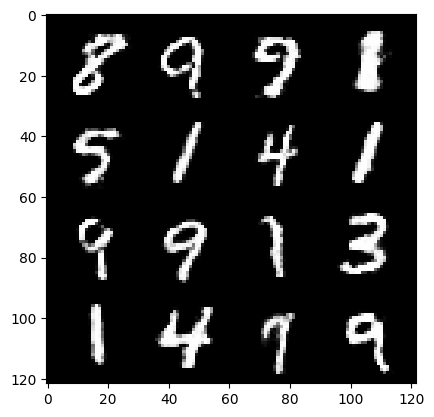

In [11]:
## 60000 images / 128 images per batch = ~469 steps per epoch
# each step is going to process 128 images = size of the batch (except in last step)

for epoch in range(epochs):
    for real, _ in tqdm(dataloader):
        ## discriminator training
        disc_opt.zero_grad()

        cur_bs = len(real) # real: 128 x 1 x 28 x 28
        real = real.view(cur_bs, -1) # 128 x 784
        real = real.to(device)

        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)

        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        ## generator training
        gen_opt.zero_grad()
        gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        ## visualization & stats
        mean_disc_loss += disc_loss.item()/info_step
        mean_gen_loss += disc_loss.item()/info_step

        if cur_step % info_step == 0 and cur_step > 0:
            fake_noise = gen_noise(cur_bs, z_dim)
            fake = gen(fake_noise)
            # show(fake)
            save_img(fake)
            # show(real)
            print(f"{epoch}: step {cur_step} / Gen Loss: {mean_gen_loss} / Disc Loss: {mean_disc_loss}")
            mean_gen_loss, mean_disc_loss = 0,0
            output_img_counter += 1
            

        cur_step += 1